In [90]:
# !pip install tensorflow

In [91]:
import tensorflow as tf
from  tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
tf.test.gpu_device_name()

'/device:GPU:0'

In [92]:
df = pd.read_csv('/content/cleaned_data.csv')

In [93]:
y = df['Credit_Status']
X = df.drop('Credit_Status',axis = 1)

In [94]:
X_train ,X_test,y_train,y_test = train_test_split(X,y ,random_state = 42 , stratify= y ,test_size = 0.2 )

In [95]:
cols = list(X_train.columns)

In [96]:


# Define a custom function to calculate F1 score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [97]:
def ANN_binary(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(48, input_dim= 10 , activation='relu'),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics= f1_score)

    if weights == -1:
        model.fit(X_train, y_train, epochs=50)
    else:
        model.fit(X_train, y_train, epochs=50, class_weight = weights)

    print(model.evaluate(X_test, y_test))

    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_test, y_preds))
    model.save('/content/my_model.h5')
    return y_preds

In [98]:
ANN_binary(X_train, y_train, X_test, y_test, 'binary_crossentropy', weights = -1)

Epoch 1/50
815/815 [==============================] - 5s 4ms/step - loss: 0.3379 - f1_score: 0.6121
Epoch 2/50
815/815 [==============================] - 4s 5ms/step - loss: 0.2939 - f1_score: 0.7012
Epoch 3/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2846 - f1_score: 0.7093
Epoch 4/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2790 - f1_score: 0.7227
Epoch 5/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2736 - f1_score: 0.7288
Epoch 6/50
815/815 [==============================] - 4s 5ms/step - loss: 0.2685 - f1_score: 0.7407
Epoch 7/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2660 - f1_score: 0.7425
Epoch 8/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2616 - f1_score: 0.7447
Epoch 9/50
815/815 [==============================] - 3s 4ms/step - loss: 0.2597 - f1_score: 0.7494
Epoch 10/50
815/815 [==============================] - 4s 4ms/step - loss: 0.2563 - f1_score: 0.7573

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [99]:
# Load the model from the 'model.h5' file, specifying the custom metric function
model = tf.keras.models.load_model('/content/my_model.h5', custom_objects={'f1_score': f1_score})

In [100]:
y_train_pred = model.predict(X_train)

815/815 [==============================] - 1s 2ms/step


In [101]:
df1 = pd.DataFrame()

In [102]:
df1['y_prob'] = [i[0] for i in  y_train_pred]
df1['real'] = list(y_train)

In [103]:
from sklearn.metrics import f1_score
dict_of_f1 = {}
for i in range(1,10):
  df1['train_pred'] = np.where( df1['y_prob'] > i/10 ,1,0)
  dict_of_f1[f1_score(df1['real'],df1['train_pred'])] = i/10

In [104]:
dict_of_f1

{0.6017607457276023: 0.1,
 0.7319798552093171: 0.2,
 0.782354552927208: 0.3,
 0.7989077433196801: 0.4,
 0.8027772187562889: 0.5,
 0.798887859128823: 0.6,
 0.7872474747474747: 0.7,
 0.7669075612123827: 0.8,
 0.7254616675993285: 0.9}

Text(0.5, 1.0, 'Line Plot')

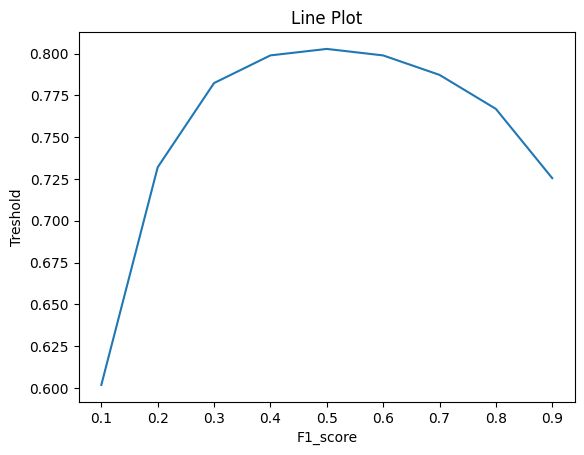

In [105]:
#
import matplotlib.pyplot as plt
# Create a line plot
plt.plot(dict_of_f1.values(),dict_of_f1.keys())
plt.plot()
# Add labels and title
plt.xlabel('F1_score')
plt.ylabel('Treshold')
plt.title('Line Plot')

In [115]:
print(f"Train_f_score: {f1_score(y_train, y_pred_train)}\nTest_f_score : {f1_score(y_test, y_pred_test)}")

Train_f_score: 0.8027772187562889
Test_f_score : 0.7753126260588948


In [109]:
model.save_weights('model_weights.h5') # save model

In [110]:
# create new model structure same params and compile it same optimization and loss function
model_main = keras.Sequential([
        keras.layers.Dense(48, input_dim= 10 , activation='relu'),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
model_main.compile(optimizer='adam',loss =  'binary_crossentropy' )

In [111]:
model_main.load_weights('my_model.h5') #use old model weights
model_main.save_weights('model_weights.h5') # integrate it to new one
model_main.save('/content/model_weights.h5') #save new model to 'model_weights.h5'

In [112]:
# the main reason to do that , i used F1_score as a funtion